In [1]:
import torch

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.00001
BATCH_SIZE = 8
NUM_EPOCHS = 150
IMAGE_SIZE = 224
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
NUM_HEADS = 8
TRANSFORMER_LAYERS = 10

PROJECTION_DIM = 128
MLP_HEAD_UNITS = [512]


Using device: cuda:0


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

image_size = 224

def find_label_from_folder(folder_name, labels):
    # Return the label whose prefix matches the folder_name
    for label in labels:
        if folder_name.startswith(label):
            return label
    raise ValueError(f"Cannot find label for folder {folder_name}")

def load_images(data_path, split_names=["train", "valid", "test"], labels=None, image_size=224):
    X = []
    y = []
    if labels is None:
        raise ValueError("You must provide the list of labels explicitly in this case.")
    for split_name in split_names:
        split_path = os.path.join(data_path, split_name)
        if not os.path.exists(split_path):
            return
        for folder_name in os.listdir(split_path):
            folder_path = os.path.join(split_path, folder_name)
            # Only process directories
            if not os.path.isdir(folder_path):
                continue
            try:
                label = find_label_from_folder(folder_name, labels)
            except ValueError as e:
                print(e)
                continue
            for img_name in tqdm(os.listdir(folder_path), desc=f"{split_name}/{folder_name}"):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Could not read image {img_path}")
                    continue
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)
                y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

data_path = ""
labels = ["adenocarcinoma", "large.cell.carcinoma", "normal", "squamous.cell.carcinoma"]

X, y = load_images(data_path, labels=labels, image_size=image_size)

train/normal: 100%|██████████| 148/148 [00:00<00:00, 371.50it/s]
train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 100%|██████████| 155/155 [00:00<00:00, 837.36it/s]
train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 100%|██████████| 115/115 [00:00<00:00, 858.95it/s]
valid/normal: 100%|██████████| 13/13 [00:00<00:00, 241.14it/s]
valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 100%|██████████| 15/15 [00:00<00:00, 907.53it/s]
valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 100%|██████████| 21/21 [00:00<00:00, 968.74it/s]
test/squamous.cell.carcinoma: 100%|██████████| 90/90 [00:00<00:00, 674.57it/s]


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision

# Define constants
IMAGE_SIZE = 224
BATCH_SIZE = 32

label2idx = {
    "normal": 0,
    "adenocarcinoma": 1,
    "large.cell.carcinoma": 2,
    "squamous.cell.carcinoma": 3
}

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

class AugmentedDataset(Dataset):
    def __init__(self, X, y, transform=None, augment_copies=0):
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Normalize and permute input images
        X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
        encoded_labels = [label2idx[l] if isinstance(l, str) else l for l in y]

        for img, label in zip(X, encoded_labels):
            self.images.append(img)
            self.labels.append(label)

            for _ in range(augment_copies):
                if self.transform:
                    aug_img = self.transform(img)
                    self.images.append(aug_img)
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]



train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.RandomRotation(degrees=7),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.Normalize(mean, std),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.Normalize(mean, std),
])


train_dataset = AugmentedDataset(X_train, y_train, transform=train_transforms)

test_dataset = AugmentedDataset(X_test, y_test, transform=test_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Cleanup
# del train_dataset, valid_dataset, test_dataset

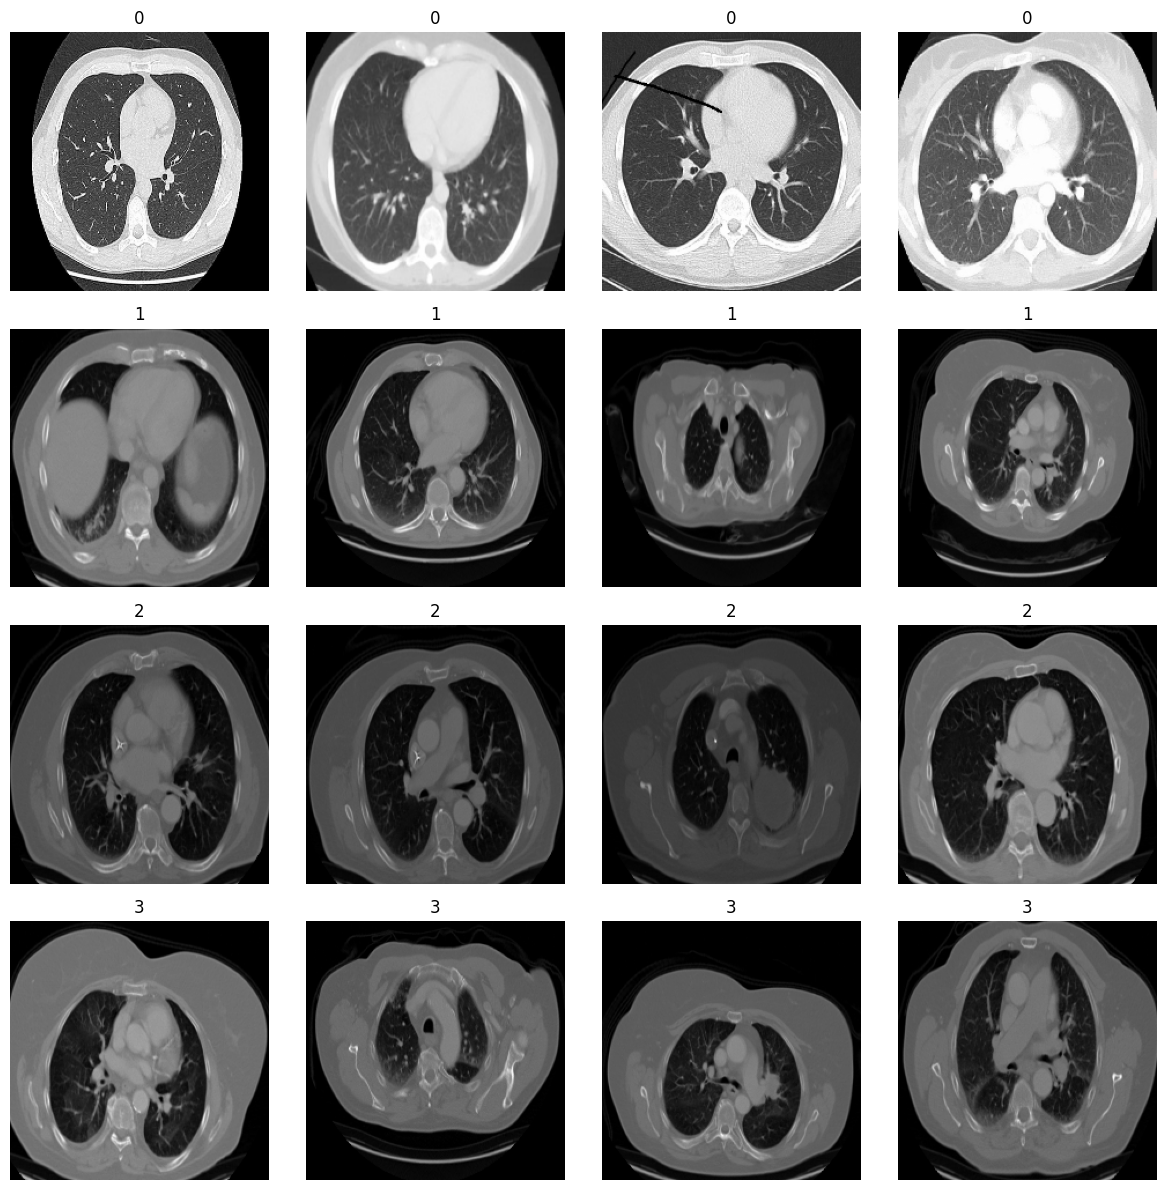

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(labels), 4, figsize=(12, len(labels) * 3))
labels = np.arange(4)
if len(labels) == 1:
    axes = np.expand_dims(axes, axis=0)

for i, label in enumerate(labels):
    indices = np.where(test_dataset.labels == label)[0]
    num_to_sample = len(indices)
    random_indices = np.random.choice(indices, size=num_to_sample, replace=False)
    for j in range(4):  # Always loop over 4 columns
        ax = axes[i, j]
        if j < num_to_sample:
            img = test_dataset.images[random_indices[j]]
            if isinstance(img, torch.Tensor):
                img = img.numpy()
                if img.ndim == 3 and img.shape[0] in [1, 3]:  # Likely CHW
                    img = np.transpose(img, (1, 2, 0))  # Convert to HWC
            
            elif isinstance(img, Image.Image):
                img = np.array(img)
            
            if isinstance(img, np.ndarray):
                if img.ndim == 3 and img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
            else:
                print(f"Unexpected type: {type(img)}")
            ax.imshow(img)
            ax.set_title(label)
        else:
            ax.axis("off")  # Hide unused subplots if less than 4 images available
        ax.axis("off")

plt.tight_layout()
plt.show()


In [6]:
from typing import Type

import torch


class CreatePatchesLayer(torch.nn.Module):
    """Custom PyTorch Layer to Extract Patches from Images."""

    def __init__(
        self,
        patch_size: int,
        strides: int,
    ) -> None:
        """Init Variables."""
        super().__init__()
        self.unfold_layer = torch.nn.Unfold(
            kernel_size=patch_size, stride=strides
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """Forward Pass to Create Patches."""
        patched_images = self.unfold_layer(images)
        return patched_images.permute((0, 2, 1))


class PatchEmbeddingLayer(torch.nn.Module):
    """Positional Embedding Layer for Images of Patches."""

    def __init__(
        self,
        num_patches: int,
        batch_size: int,
        patch_size: int,
        embed_dim: int,
        device: torch.device,
    ) -> None:
        """Init Function."""
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.position_emb = torch.nn.Embedding(
            num_embeddings=num_patches + 1, embedding_dim=embed_dim
        )
        self.projection_layer = torch.nn.Linear(
            patch_size * patch_size * 3, embed_dim
        )
        self.class_parameter = torch.nn.Parameter(
            torch.rand(1, 1, embed_dim).to(device),
            requires_grad=True,
        )

        self.device = device

    def forward(self, patches: torch.Tensor) -> torch.Tensor:
        """Forward Pass."""
        positions = (
            torch.arange(start=0, end=self.num_patches + 1, step=1)
            .to(self.device)
            .unsqueeze(dim=0)
        )
        patches = self.projection_layer(patches)
        b = patches.shape[0]
        cls_token = self.class_parameter.expand(b, -1, -1)
        encoded_patches = torch.cat(
            (cls_token, patches), dim=1
        ) + self.position_emb(positions)
        return encoded_patches

def create_mlp_block(
    input_features: int,
    output_features: list[int],
    activation_function: Type[torch.nn.Module],
    dropout_rate: float,
) -> torch.nn.Module:
    """Create a Feed Forward Network for the Transformer Layer."""
    layer_list = []
    for idx in range(
        len(output_features)
    ):
        if idx == 0:
            linear_layer = torch.nn.Linear(
                in_features=input_features, out_features=output_features[idx]
            )
        else:
            linear_layer = torch.nn.Linear(
                in_features=output_features[idx - 1],
                out_features=output_features[idx],
            )
        dropout = torch.nn.Dropout(p=dropout_rate)
        layers = torch.nn.Sequential(
            linear_layer, activation_function(), dropout
        )
        layer_list.append(layers)
    return torch.nn.Sequential(*layer_list)


class TransformerBlock(torch.nn.Module):
    """Transformer Block Layer with Residual Connections."""

    def __init__(
        self,
        num_heads: int,
        key_dim: int,
        embed_dim: int,
        ff_dim: int,
        dropout_rate: float = 0.4,
    ) -> None:
        super().__init__()

        self.norm1 = torch.nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = torch.nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            kdim=key_dim,
            vdim=key_dim,
            batch_first=True,
        )
        self.dropout1 = torch.nn.Dropout(dropout_rate)

        # LayerNorm before FFN
        self.norm2 = torch.nn.LayerNorm(embed_dim, eps=1e-6)
        self.ffn = create_mlp_block(
            input_features=embed_dim,
            output_features=[ff_dim, embed_dim],
            activation_function=torch.nn.GELU,
            dropout_rate=dropout_rate,
        )
        self.dropout2 = torch.nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Residual connection around Multi-head Attention
        x_norm1 = self.norm1(x)
        attn_output, _ = self.attn(x_norm1, x_norm1, x_norm1)
        x = x + self.dropout1(attn_output)

        # Residual connection around Feed Forward Network
        x_norm2 = self.norm2(x)
        ffn_output = self.ffn(x_norm2)
        x = x + self.dropout2(ffn_output)

        return x


class ViTClassifierModel(torch.nn.Module):
  """ViT Model for Image Classification."""

  def __init__(
    self,
    num_transformer_layers: int,
    embed_dim: int,
    feed_forward_dim: int,
    num_heads: int,
    patch_size: int,
    num_patches: int,
    mlp_head_units: list[int],
    num_classes: int,
    batch_size: int,
    device: torch.device,
  ) -> None:
    """Init Function."""
    super().__init__()
    self.create_patch_layer = CreatePatchesLayer(patch_size, patch_size)
    self.patch_embedding_layer = PatchEmbeddingLayer(
      num_patches, batch_size, patch_size, embed_dim, device
    )
    self.transformer_layers = torch.nn.ModuleList()
    for _ in range(num_transformer_layers):
      self.transformer_layers.append(
        TransformerBlock(
          num_heads, embed_dim, embed_dim, feed_forward_dim
        )
      )

    self.mlp_block = create_mlp_block(
      input_features=embed_dim,
      output_features=mlp_head_units,
      activation_function=torch.nn.GELU,
        dropout_rate=0.4,
      )

    self.logits_layer = torch.nn.Linear(mlp_head_units[-1], num_classes)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward Pass."""
    x = self.create_patch_layer(x)
    x = self.patch_embedding_layer(x)
    for transformer_layer in self.transformer_layers:
      x = transformer_layer(x)
    x = x[:, 0]
    x = self.mlp_block(x)
    x = self.logits_layer(x)
    return x

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

def train(model, train_loader, valid_loader, epochs = 100):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(device)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min = 1e-5)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        validate(model, valid_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {(total_loss/len(train_loader)):.4f}")


def validate(model, valid_loader):
    model.eval()
    correct, total = 0, 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for X, y in tqdm(valid_loader):
            X, y = X.to(device), y.to(device)
            outputs = model(X)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    acc = correct / total
    
    print(f"Validation Accuracy: {acc*100:.2f}%")

def test_and_report(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X, y in tqdm(test_loader):
            X = X.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(label2idx.keys())))


In [8]:
model = ViTClassifierModel(
    num_transformer_layers = TRANSFORMER_LAYERS,
    embed_dim = PROJECTION_DIM,
    feed_forward_dim = PROJECTION_DIM*2,
    num_heads = NUM_HEADS,
    patch_size = PATCH_SIZE,
    num_patches = NUM_PATCHES,
    mlp_head_units = MLP_HEAD_UNITS,
    num_classes = 4,
    batch_size = BATCH_SIZE,
    device = device,
  ) 

# Train
train(model, train_loader, test_loader, epochs=NUM_EPOCHS)

# Test
print("Scores on test data:")
test_and_report(model, test_loader)

100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Validation Accuracy: 36.00%
Epoch 1/150, Loss: 1.3966


100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


Validation Accuracy: 53.50%
Epoch 2/150, Loss: 1.2804


100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


Validation Accuracy: 57.50%
Epoch 3/150, Loss: 1.1416


100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


Validation Accuracy: 61.00%
Epoch 4/150, Loss: 1.0810


100%|██████████| 7/7 [00:00<00:00,  7.30it/s]


Validation Accuracy: 51.00%
Epoch 5/150, Loss: 1.0099


100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


Validation Accuracy: 58.00%
Epoch 6/150, Loss: 0.9714


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Validation Accuracy: 63.50%
Epoch 7/150, Loss: 0.9367


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 50.00%
Epoch 8/150, Loss: 0.9011


100%|██████████| 7/7 [00:01<00:00,  6.96it/s]


Validation Accuracy: 62.50%
Epoch 9/150, Loss: 0.8634


100%|██████████| 7/7 [00:01<00:00,  6.94it/s]


Validation Accuracy: 61.50%
Epoch 10/150, Loss: 0.8351


100%|██████████| 7/7 [00:01<00:00,  6.90it/s]


Validation Accuracy: 58.00%
Epoch 11/150, Loss: 0.8376


100%|██████████| 7/7 [00:01<00:00,  6.88it/s]


Validation Accuracy: 57.00%
Epoch 12/150, Loss: 0.8646


100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


Validation Accuracy: 68.50%
Epoch 13/150, Loss: 0.7991


100%|██████████| 7/7 [00:01<00:00,  6.82it/s]


Validation Accuracy: 61.50%
Epoch 14/150, Loss: 0.7687


100%|██████████| 7/7 [00:01<00:00,  6.83it/s]


Validation Accuracy: 67.50%
Epoch 15/150, Loss: 0.6789


100%|██████████| 7/7 [00:01<00:00,  6.85it/s]


Validation Accuracy: 65.50%
Epoch 16/150, Loss: 0.7546


100%|██████████| 7/7 [00:01<00:00,  6.91it/s]


Validation Accuracy: 70.50%
Epoch 17/150, Loss: 0.7061


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Validation Accuracy: 66.50%
Epoch 18/150, Loss: 0.6789


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 69.00%
Epoch 19/150, Loss: 0.6389


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Validation Accuracy: 70.50%
Epoch 20/150, Loss: 0.6570


100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


Validation Accuracy: 70.00%
Epoch 21/150, Loss: 0.5831


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Validation Accuracy: 72.50%
Epoch 22/150, Loss: 0.5687


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Validation Accuracy: 70.50%
Epoch 23/150, Loss: 0.5464


100%|██████████| 7/7 [00:00<00:00,  7.14it/s]


Validation Accuracy: 68.50%
Epoch 24/150, Loss: 0.5726


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Validation Accuracy: 73.00%
Epoch 25/150, Loss: 0.5211


100%|██████████| 7/7 [00:00<00:00,  7.12it/s]


Validation Accuracy: 73.00%
Epoch 26/150, Loss: 0.5060


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Validation Accuracy: 69.50%
Epoch 27/150, Loss: 0.5240


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


Validation Accuracy: 69.00%
Epoch 28/150, Loss: 0.4482


100%|██████████| 7/7 [00:00<00:00,  7.10it/s]


Validation Accuracy: 71.00%
Epoch 29/150, Loss: 0.4433


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 79.00%
Epoch 30/150, Loss: 0.4076


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 74.00%
Epoch 31/150, Loss: 0.3648


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 75.00%
Epoch 32/150, Loss: 0.3711


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Validation Accuracy: 73.50%
Epoch 33/150, Loss: 0.4133


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Validation Accuracy: 73.50%
Epoch 34/150, Loss: 0.3679


100%|██████████| 7/7 [00:00<00:00,  7.00it/s]


Validation Accuracy: 79.00%
Epoch 35/150, Loss: 0.3586


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Validation Accuracy: 76.50%
Epoch 36/150, Loss: 0.3344


100%|██████████| 7/7 [00:01<00:00,  6.98it/s]


Validation Accuracy: 80.00%
Epoch 37/150, Loss: 0.2496


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


Validation Accuracy: 80.50%
Epoch 38/150, Loss: 0.2461


100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Validation Accuracy: 76.00%
Epoch 39/150, Loss: 0.2223


100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Validation Accuracy: 75.00%
Epoch 40/150, Loss: 0.2200


100%|██████████| 7/7 [00:01<00:00,  7.00it/s]


Validation Accuracy: 78.50%
Epoch 41/150, Loss: 0.1947


100%|██████████| 7/7 [00:00<00:00,  7.01it/s]


Validation Accuracy: 80.00%
Epoch 42/150, Loss: 0.1906


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 80.00%
Epoch 43/150, Loss: 0.2479


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 80.00%
Epoch 44/150, Loss: 0.2036


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 76.50%
Epoch 45/150, Loss: 0.1968


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 81.50%
Epoch 46/150, Loss: 0.2168


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 81.50%
Epoch 47/150, Loss: 0.1191


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 76.00%
Epoch 48/150, Loss: 0.1388


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 75.50%
Epoch 49/150, Loss: 0.2121


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 76.50%
Epoch 50/150, Loss: 0.2290


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 80.50%
Epoch 51/150, Loss: 0.1296


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 81.50%
Epoch 52/150, Loss: 0.1158


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 78.00%
Epoch 53/150, Loss: 0.0827


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Validation Accuracy: 77.00%
Epoch 54/150, Loss: 0.1050


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Validation Accuracy: 79.50%
Epoch 55/150, Loss: 0.0901


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 80.00%
Epoch 56/150, Loss: 0.1031


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Validation Accuracy: 82.50%
Epoch 57/150, Loss: 0.0480


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 80.50%
Epoch 58/150, Loss: 0.0454


100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Validation Accuracy: 80.50%
Epoch 59/150, Loss: 0.0308


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 77.00%
Epoch 60/150, Loss: 0.0388


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Validation Accuracy: 80.50%
Epoch 61/150, Loss: 0.1486


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 85.50%
Epoch 62/150, Loss: 0.1303


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 80.00%
Epoch 63/150, Loss: 0.0690


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 79.50%
Epoch 64/150, Loss: 0.0682


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 82.00%
Epoch 65/150, Loss: 0.0780


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 79.50%
Epoch 66/150, Loss: 0.0377


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 77.00%
Epoch 67/150, Loss: 0.0453


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 81.00%
Epoch 68/150, Loss: 0.0550


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 80.50%
Epoch 69/150, Loss: 0.0590


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 80.00%
Epoch 70/150, Loss: 0.0574


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 78.50%
Epoch 71/150, Loss: 0.0202


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 81.50%
Epoch 72/150, Loss: 0.0210


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 80.50%
Epoch 73/150, Loss: 0.0289


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 80.00%
Epoch 74/150, Loss: 0.0237


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 79.00%
Epoch 75/150, Loss: 0.0222


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 79.00%
Epoch 76/150, Loss: 0.0485


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 79.00%
Epoch 77/150, Loss: 0.0528


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 78.00%
Epoch 78/150, Loss: 0.0316


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 79.50%
Epoch 79/150, Loss: 0.0119


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 78.00%
Epoch 80/150, Loss: 0.0255


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 78.50%
Epoch 81/150, Loss: 0.0224


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 77.00%
Epoch 82/150, Loss: 0.0055


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 77.50%
Epoch 83/150, Loss: 0.0034


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 80.50%
Epoch 84/150, Loss: 0.0123


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 80.50%
Epoch 85/150, Loss: 0.0137


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 78.00%
Epoch 86/150, Loss: 0.0307


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 79.50%
Epoch 87/150, Loss: 0.0319


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 81.50%
Epoch 88/150, Loss: 0.0421


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 81.50%
Epoch 89/150, Loss: 0.0148


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 82.50%
Epoch 90/150, Loss: 0.0135


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 82.00%
Epoch 91/150, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 83.50%
Epoch 92/150, Loss: 0.0050


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 84.00%
Epoch 93/150, Loss: 0.0080


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 80.50%
Epoch 94/150, Loss: 0.0130


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Validation Accuracy: 81.00%
Epoch 95/150, Loss: 0.0170


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 80.50%
Epoch 96/150, Loss: 0.0107


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 81.50%
Epoch 97/150, Loss: 0.0063


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 82.00%
Epoch 98/150, Loss: 0.0025


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Validation Accuracy: 81.50%
Epoch 99/150, Loss: 0.0092


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Validation Accuracy: 84.00%
Epoch 100/150, Loss: 0.0076


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 83.50%
Epoch 101/150, Loss: 0.0087


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Validation Accuracy: 83.00%
Epoch 102/150, Loss: 0.0027


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 82.00%
Epoch 103/150, Loss: 0.0010


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 83.00%
Epoch 104/150, Loss: 0.0008


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


Validation Accuracy: 83.50%
Epoch 105/150, Loss: 0.0014


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 82.00%
Epoch 106/150, Loss: 0.0011


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 83.50%
Epoch 107/150, Loss: 0.0008


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 83.50%
Epoch 108/150, Loss: 0.0013


100%|██████████| 7/7 [00:00<00:00,  7.06it/s]


Validation Accuracy: 84.00%
Epoch 109/150, Loss: 0.0022


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 82.50%
Epoch 110/150, Loss: 0.0028


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 83.50%
Epoch 111/150, Loss: 0.0013


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 84.00%
Epoch 112/150, Loss: 0.0042


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 85.50%
Epoch 113/150, Loss: 0.0014


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 85.00%
Epoch 114/150, Loss: 0.0074


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 86.50%
Epoch 115/150, Loss: 0.0026


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 84.50%
Epoch 116/150, Loss: 0.0015


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 84.50%
Epoch 117/150, Loss: 0.0010


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 85.50%
Epoch 118/150, Loss: 0.0008


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 84.50%
Epoch 119/150, Loss: 0.0012


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 85.00%
Epoch 120/150, Loss: 0.0003


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 84.50%
Epoch 121/150, Loss: 0.0050


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 86.50%
Epoch 122/150, Loss: 0.0006


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 85.50%
Epoch 133/150, Loss: 0.0003


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 85.00%
Epoch 134/150, Loss: 0.0002


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 85.00%
Epoch 135/150, Loss: 0.0002


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 85.00%
Epoch 136/150, Loss: 0.0012


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 85.00%
Epoch 137/150, Loss: 0.0005


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 85.00%
Epoch 138/150, Loss: 0.0002


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 85.00%
Epoch 139/150, Loss: 0.0010


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 85.00%
Epoch 140/150, Loss: 0.0007


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 85.00%
Epoch 141/150, Loss: 0.0006


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]


Validation Accuracy: 85.00%
Epoch 142/150, Loss: 0.0004


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 85.00%
Epoch 143/150, Loss: 0.0002


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 85.00%
Epoch 144/150, Loss: 0.0008


100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Validation Accuracy: 85.00%
Epoch 145/150, Loss: 0.0001


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 85.00%
Epoch 146/150, Loss: 0.0002


100%|██████████| 7/7 [00:00<00:00,  7.04it/s]


Validation Accuracy: 85.00%
Epoch 147/150, Loss: 0.0002


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 85.00%
Epoch 148/150, Loss: 0.0010


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 85.00%
Epoch 149/150, Loss: 0.0001


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]


Validation Accuracy: 85.00%
Epoch 150/150, Loss: 0.0002
Scores on test data:


100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

Confusion Matrix:
[[50  0  0  0]
 [ 1 55  4  8]
 [ 0  5 26  1]
 [ 0  8  3 39]]

Classification Report:
                         precision    recall  f1-score   support

                 normal       0.98      1.00      0.99        50
         adenocarcinoma       0.81      0.81      0.81        68
   large.cell.carcinoma       0.79      0.81      0.80        32
squamous.cell.carcinoma       0.81      0.78      0.80        50

               accuracy                           0.85       200
              macro avg       0.85      0.85      0.85       200
           weighted avg       0.85      0.85      0.85       200

